In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [9]:
# Save references to each table
Stations = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).\
    order_by(desc(Measurement.date)).\
    first()

print(most_recent_date)

('2017-08-23',)


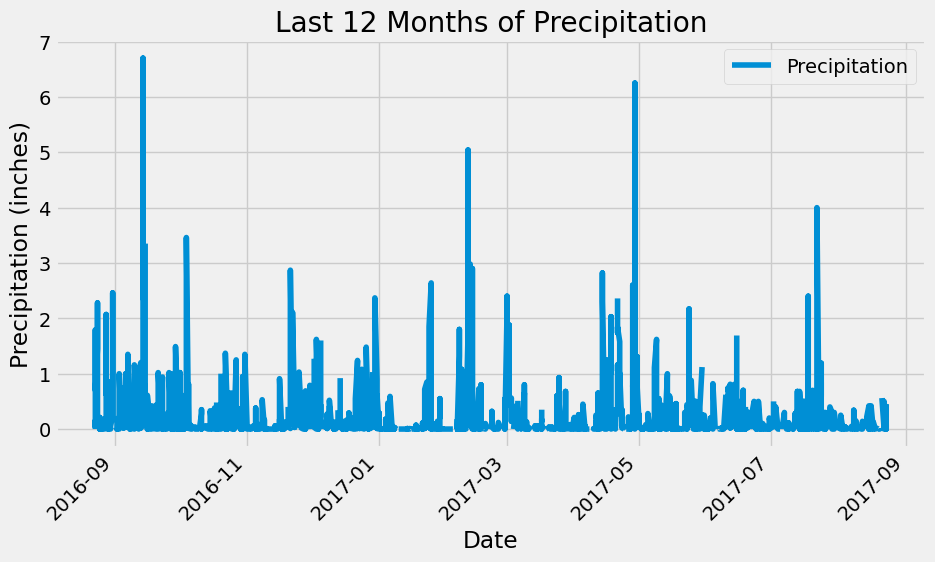

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).\
    order_by(desc(Measurement.date)).\
    first().date

# Calculate the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('Date', inplace=True)
precipitation_df.plot(rot=45, figsize=(10, 6))
plt.title('Last 12 Months of Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()

precipitation_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
Station = Base.classes.station

total_stations = session.query(func.count(Station.station)).scalar()

print(total_stations)

9


In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0] 

temperature_stats = session.query(
    func.min(Measurement.tobs).label('Lowest Temperature'),
    func.max(Measurement.tobs).label('Highest Temperature'),
    func.avg(Measurement.tobs).label('Average Temperature')
).filter(Measurement.station == most_active_station).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

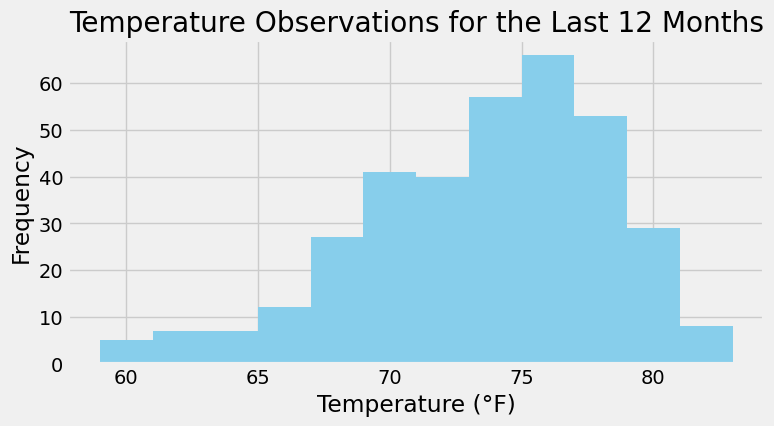

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Find the date one_year_ago
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

#Query the last 12 months of temperature data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

temperatures = [temp.tobs for temp in temperature_data]

#Plot the results
plt.figure(figsize=(8, 4))
plt.hist(temperatures, bins=12, color='skyblue')
plt.title(f'Temperature Observations for the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show();

# Close Session

In [50]:
# Close Session
session.close()